In [0]:
!wget --load-cookies cookies.txt 'https://docs.google.com/uc?export=download&confirm='"$(wget --save-cookies cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')"'&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM' -O img_align_celeba.zip
!unzip -q img_align_celeba

In [0]:
# !mkdir ./train/
# !mv ./img_align_celeba/ ./train/img_align_celeba/
# !mv cookies.txt ./train/
from google.colab import drive
drive.mount('/content/gdrive')
# !ls ./train/


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip3 install torch 
!pip3 install torchvision
!pip3 install tqdm
!pip install pbd
!pip install Pillow
!pip install image
!pip install --no-cache-dir -I pillow

import torch
from io import open
import string
import re
import random
from tqdm import tqdm
from torch import autograd

import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import string
import random
import re
 
from torchvision import transforms, utils, datasets
import torchvision
import pdb

from torch.autograd import Variable
import time
import numpy as np
import matplotlib.pyplot as plt
import os

import torch as t
from torchvision.transforms import ToPILImage
from IPython.display import Image

import gc

beta1 = 0.5 # 0
beta2 = 0.999 # 0.9
lambda_ = 10
ncritic = 1 # 5
alpha = 0.0004 # 0.0001
critic_iters = 2
batch_size= 200

batch_norm_decay=0.9
# batch_norm_epsilon=1e-5

    100% |████████████████████████████████| 519.5MB 29kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x589f0000 @  0x7f0465b3f2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 3.5MB/s 
    100% |████████████████████████████████| 2.0MB 10.7MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  Running setup.py bdist_wheel for pbd ... - done
  Stored in directory: /root/.cache/pip/wheels/27/d2/a5/caefc1f51c049318659cfe9d699d4ba10c3f084fc925d8c533
Successfully built pbd
    100% |████████████████████████████████| 7.3MB 5.5MB/s 
    100% |████████████████████████████████| 2.0MB 21.9MB/s 


In [0]:
class CelebaDataset(Dataset):
  def __init__(self, root, size=128, train=True):
    super(CelebaDataset, self).__init__()
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root) ,transform = transforms.Compose([transforms.Resize((size,size)),transforms.ToTensor()]))
    
  def __getitem__(self,index):
    img = self.dataset_folder[index]
    return img[0]
 
  def __len__(self):
    return 200000
#     return len(self.dataset_folder)


class GeneratorModel(nn.Module):
  def __init__(self):
    super(GeneratorModel, self).__init__()
    
    self.linear = nn.Linear(100,4*4*1024)
        
    self.net = nn.Sequential(
              nn.ConvTranspose2d(1024, 512, 2, stride=2),
              nn.ReLU(),
              nn.BatchNorm2d(512, momentum=batch_norm_decay),
              nn.ConvTranspose2d(512, 256, 2, stride=2),
              nn.ReLU(),
              nn.BatchNorm2d(256, momentum=batch_norm_decay),
              nn.ConvTranspose2d(256, 128, 2, stride=2),
              nn.ReLU(),
              nn.BatchNorm2d(128, momentum=batch_norm_decay),
              nn.ConvTranspose2d(128, 64, 2, stride=2),
              nn.ReLU(),
              nn.BatchNorm2d(64, momentum=batch_norm_decay),
              nn.ConvTranspose2d(64, 3, 2, stride=2),
              nn.Sigmoid()
              )
      
  def forward(self, z):
    x = self.linear(z).view(-1, 1024, 4, 4)
    return self.net(x)
  
class DiscriminatorModel(nn.Module):
  def __init__(self):
    super(DiscriminatorModel, self).__init__()
    
    self.linear = nn.Linear(batch_size*2*128*128, 1)
    
    self.net = nn.Sequential(
              nn.Conv2d(3, 10, 3, padding=(1,1)),
              nn.LeakyReLU(),
              nn.Conv2d(10, 30, 3, padding=(1,1)),
              nn.LeakyReLU(),
              nn.BatchNorm2d(30, momentum=0.9),
              nn.Conv2d(30, 20, 3, padding=(1,1)),
              nn.LeakyReLU(),
              nn.Conv2d(20, 2, 3, padding=(1,1)),
              )
    
  def forward(self, x):
    out = self.net(x)
    out = out.view(-1, batch_size*2*128*128)
    return self.linear(out)

In [0]:
# g_model = GeneratorModel()
# z = torch.rand((batch_size,100))
# x_t = g_model(z)
# print(x_t.size())

# d_model = DiscriminatorModel()
# out = d_model(x_t)
# print(out.size())
# print(out)

# conv = nn.ConvTranspose2d(3, 3, 3, padding=(1,1))
# relu = nn.LeakyReLU()
# print(relu(conv(relu(conv(relu(conv(relu(conv(relu(conv(x_t)))))))))).size())
# print(len(train_loader))

In [0]:

#initialize your generator and discriminator models
# g_model = GeneratorModel()
g_model = torch.load('/content/gdrive/My Drive/model.pt')
g_model = g_model.cuda()
d_model = DiscriminatorModel()
d_model = d_model.cuda()

#initialize separate optimizer for both gen and disc
gen_optim = torch.optim.Adam(g_model.parameters(), lr=alpha, betas=(beta1, beta2))
disc_optim = torch.optim.Adam(d_model.parameters(), lr=alpha, betas=(beta1, beta2))

#initialize your dataset and dataloader
train_dataset = CelebaDataset('./train', train=True )
train_loader = DataLoader(train_dataset,
                       batch_size=batch_size,
                       pin_memory=True,
                       shuffle=True)

# true_img = train_dataset[0].unsqueeze(0)

d_losses_e = []
g_losses_e = []
epochs = 100

for epoch in range(epochs):
  for i, true_img in enumerate(train_loader):
    true_img = true_img.cuda()
 
    #train discriminator#
 
    #because you want to be able to backprop through the params in discriminator 
    for p in d_model.parameters():
      p.requires_grad = True

    d_losses = []

    for n in range(critic_iters):
      disc_optim.zero_grad()

      # generate noise tensor z
      z = torch.randn((batch_size,100), requires_grad=True)
      z = z.cuda()
      x_t = g_model(z)

      e = torch.rand((batch_size,1,1,1))
      e = e.cuda()
      x_hat = e*true_img
      x_hat += (1-e)*x_t

      x_hat = autograd.Variable(x_hat, requires_grad=True)
      x_hat_grad = autograd.grad(d_model(x_hat), x_hat)[0]
      disc_optim.zero_grad()

      # calculate disc loss: you will need autograd.grad
      d_loss = (d_model(x_t) - d_model(true_img) + lambda_*(torch.norm(x_hat_grad) - 1)**2).mean()
      d_losses.append(d_loss.item())
      print("Batch:", i, "LOSS: ", d_loss.item())

      # Loss Backward and step the optimizer
      d_loss.backward()
      disc_optim.step()

      d_losses_e.append(sum(d_losses)/len(d_losses))
    
     #train generator#
    for p in d_model.parameters():
      p.requires_grad = False
      
    gen_optim.zero_grad()

    # generate noise tensor z
    z = torch.randn((batch_size,100), requires_grad=True)
    z = z.cuda()
    
    # calculate loss for gen
    g_loss = -d_model(g_model(z)).mean()
    g_losses_e.append(g_loss.item())
    
    # Loss Backward and step the optimizer
    g_loss.backward()
    gen_optim.step()
    
    if(i % 50 == 0):
      print("I:", i)
      print("Epoch:", epoch+1, "Iteration:", i+1)
      z = torch.rand((batch_size,100)).cuda()
      z = z.cuda()
      x = g_model(z)
      x = x.squeeze(0)[0]
      print(x.size())
      pic = x.cpu().detach().permute(1,2,0).numpy()
      plt.imshow(pic)
      plt.show()
      
  torch.save(g_model.cpu(), '/content/gdrive/My Drive/model.pt')
  gc.collect()
  g_model = g_model.cuda()
  print("Epoch", epoch, "Finished")
      
# loop.close()

FileNotFoundError: ignored

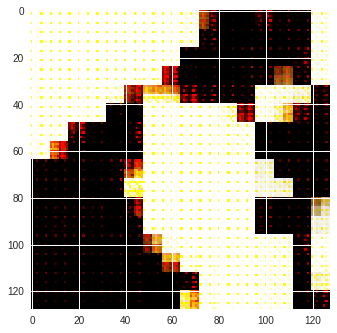

In [0]:
z = torch.randn((1,100))
pic = g_model(z).squeeze(0)
# print(pic.size())
pic = g_model(z).squeeze(0).permute(1,2,0).cpu().detach().numpy()
# print(type(pic))
# print(pic)
plt.imshow(pic)
plt.show()

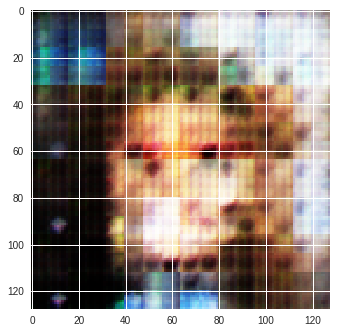

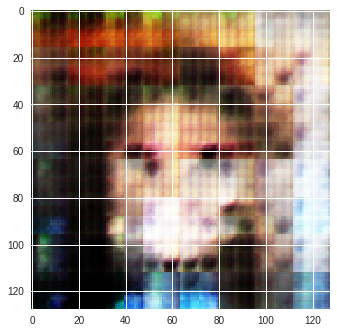

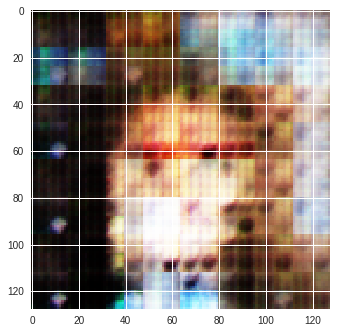

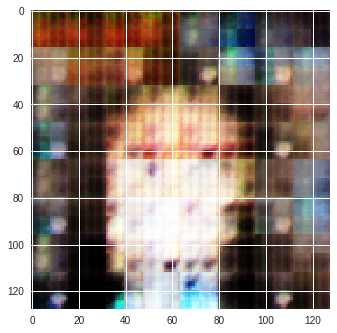

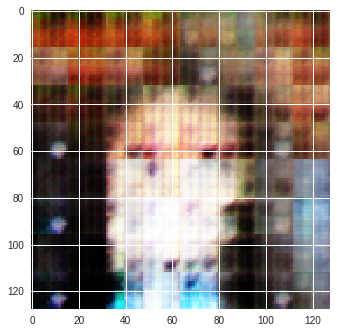

In [0]:
 # from google.colab import drive
# drive.mount('/content/gdrive')
g_model = torch.load('/content/gdrive/My Drive/model.pt')
for _ in range(5):

  z = torch.rand((1,100))
  pic = g_model(z).squeeze(0)
  # print(pic.size())
  pic = g_model(z).squeeze(0).permute(1,2,0).cpu().detach().numpy()
  # print(type(pic))
  # print(pic)
  plt.imshow(pic)
  plt.show()

In [0]:
plt.plot(list(range(epochs)), d_losses_e, label='Desciminator Losses')
plt.plot(list(range(epochs)), g_losses_e, label='Generator Losses')

val_loss_x, val_loss_y = zip(*validation_losses)
plt.plot(val_loss_x, val_loss_y, label='Validation Loop')
plt.legend()
plt.title("LOSS")
plt.show()

NameError: ignored